Welcome to the sagemaker integration for cmle, the goal of this notebook is to show you an example of how to featurize data that currently lives in the dlz and bring that data into the sagemaker environment.   The notebook simulates the equivalent of the original Week3 notebook by loading in custom jars that are necessary to launch a spark session and then initiate model training by running mlflow locally within the sagemaker environment.  The goal is to show how to launch mlflow within the sagemaker docker image that is used to run this notebook.  Fundamentally all other parts of the notebook stay the same as the original Week3 notebook.

First lets install some linux dependencies that are needed for java and other dependencies for the spark installation

In [2]:
!apt update -y
!apt install software-properties-common -y
!apt install default-jdk -y

Hit:1 http://deb.debian.org/debian bullseye InRelease
Get:2 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Get:3 http://security.debian.org/debian-security bullseye-security InRelease [48.4 kB]
Get:4 http://deb.debian.org/debian bullseye-updates/main amd64 Packages.diff/Index [21.8 kB]
Get:5 http://deb.debian.org/debian bullseye-updates/main amd64 Packages T-2023-09-14-2007.09-F-2023-08-26-1408.20.pdiff [1069 B]
Get:5 http://deb.debian.org/debian bullseye-updates/main amd64 Packages T-2023-09-14-2007.09-F-2023-08-26-1408.20.pdiff [1069 B]
Get:6 http://deb.debian.org/debian bullseye-updates/main amd64 Packages [17.5 kB]
Get:7 http://security.debian.org/debian-security bullseye-security/main amd64 Packages [247 kB]
Fetched 380 kB in 0s (1080 kB/s)33m0m
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
154 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tr

In [3]:
!java -version

openjdk version "11.0.18" 2023-01-17
OpenJDK Runtime Environment (build 11.0.18+10-post-Debian-1deb11u1)
OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Debian-1deb11u1, mixed mode, sharing)


Now lets explictly point out where JAVA_HOME is installed and install all the necessary python dependencies

In [4]:
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

In [46]:
!python3 -m pip install --upgrade pip
!python3 -m pip install pandas 
!python3 -m pip install pydeequ 
!python3 -m pip install pyspark 
!python3 -m pip install sagemaker_pyspark 
!python3 -m pip install mlflow-skinny
!python3 -m pip install aepp 
!python3 -m pip install adlfs 
!python3 -m pip install hyperopt 
!python3 -m pip install scikit-learn 
!python3 -m pip install plotly 
!python3 -m pip install hyperopt
!python3 -m pip install --upgrade nbformat

In [5]:
%env SPARK_VERSION='3.3.0'

env: SPARK_VERSION='3.3.0'


In [6]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
import sagemaker_pyspark
import botocore.session

session = botocore.session.get_session()
credentials = session.get_credentials()

conf = (SparkConf()
        .set("spark.driver.extraClassPath", ":".join(sagemaker_pyspark.classpath_jars())))

print(str(sagemaker_pyspark.classpath_jars()))

spark = (
    SparkSession
    .builder
    .config(conf=conf) \
    .config('fs.s3a.access.key', credentials.access_key)
    .config('fs.s3a.secret.key', credentials.secret_key)
    .config("spark.jars", "/root/jars/hadoop-aws-3.3.6.jar,/root/jars/hadoop-azure-3.3.6.jar,/root/jars/azsastknprovider-1.0-SNAPSHOT.jar,/root/jars/hadoop-common-3.3.6.jar")
    .appName("schema_test")
    .getOrCreate()
)
print(spark.version)

['/usr/local/lib/python3.8/site-packages/sagemaker_pyspark/jars/aws-java-sdk-bundle-1.11.901.jar', '/usr/local/lib/python3.8/site-packages/sagemaker_pyspark/jars/aws-java-sdk-core-1.12.262.jar', '/usr/local/lib/python3.8/site-packages/sagemaker_pyspark/jars/aws-java-sdk-kms-1.12.262.jar', '/usr/local/lib/python3.8/site-packages/sagemaker_pyspark/jars/aws-java-sdk-s3-1.12.262.jar', '/usr/local/lib/python3.8/site-packages/sagemaker_pyspark/jars/aws-java-sdk-sagemaker-1.12.262.jar', '/usr/local/lib/python3.8/site-packages/sagemaker_pyspark/jars/aws-java-sdk-sagemakerruntime-1.12.262.jar', '/usr/local/lib/python3.8/site-packages/sagemaker_pyspark/jars/aws-java-sdk-sts-1.12.262.jar', '/usr/local/lib/python3.8/site-packages/sagemaker_pyspark/jars/hadoop-aws-3.3.1.jar', '/usr/local/lib/python3.8/site-packages/sagemaker_pyspark/jars/sagemaker-spark_2.12-spark_3.3.0-1.4.5.jar']


23/09/19 15:30:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/19 15:30:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
3.3.0


In [8]:
import re

username = "sagemakeruser_123"
unique_id = s = re.sub("[^0-9a-zA-Z]+", "_", username)

In [9]:
import os
from configparser import ConfigParser
os.environ['ADOBE_HOME'] = "../../"
config = ConfigParser()
config_path = os.path.join(os.environ["ADOBE_HOME"], "conf", "config.ini")
if not os.path.exists(config_path):
  raise Exception(f"Looking for configuration under {config_path} but config not found, please verify path")

config.read(config_path)
ims_org_id = config.get("Platform", "ims_org_id")
sandbox_name = config.get("Platform", "sandbox_name")
environment = config.get("Platform", "environment")
client_id = config.get("Authentication", "client_id")
client_secret = config.get("Authentication", "client_secret")
private_key_path = config.get("Authentication", "private_key_path")
tech_account_id = config.get("Authentication", "tech_acct_id")
dataset_id = config.get("Platform", "dataset_id")
featurized_dataset_id = config.get("Platform", "featurized_dataset_id")
export_path = config.get("Cloud", "export_path")
import_path = config.get("Cloud", "import_path")
data_format = config.get("Cloud", "data_format")
compression_type = config.get("Cloud", "compression_type")
model_name = config.get("Cloud", "model_name")

s3_bucket_name=config.get("AWS","s3_bucket_name")
s3_prefix=config.get("AWS","s3_prefix")


if not os.path.exists(private_key_path):
  raise Exception(f"Looking for private key file under {private_key_path} but key not found, please verify path")

In [10]:
import aepp

aepp.configure(
  environment=environment,
  sandbox=sandbox_name,
  org_id=ims_org_id,
  tech_id=tech_account_id, 
  secret=client_secret,
  path_to_key=private_key_path,
  client_id=client_id
)

The cell below outlines one of the most important objectives in this notebook, namely the ability to bring in data from the 
S3 into the sagemaker environment

In [ ]:
import boto3

s3 = boto3.resource('s3')
bucket = s3.Bucket(s3_bucket_name)
objects = bucket.objects.filter(
    Prefix=f'{s3_prefix}/{featurized_dataset_id}',
    MaxKeys=1
)

for obj in objects:
    obj = obj

print(obj.key)

parts = obj.key.split('/')
for part in parts:
    if part.startswith('exportTime'):
        export_time = part.split('=')[1]

print(f'Using featurized data export time of {export_time}')

The cell below shows the characteristics of the dataframe being brought in from the dlz.

In [ ]:
parquet_s3a_path = f's3a://{s3_bucket_name}/{obj.key}'
print(parquet_s3a_path)
df = spark.read.parquet(parquet_s3a_path)
df.printSchema()

In [55]:
sampling_ratio = 0.5
df = df.sample(withReplacement=False, fraction=sampling_ratio)

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from pyspark.sql.functions import date_format

df_train = df.withColumn("timestamp", date_format("timestamp", "yyyy-MM-dd HH:mm:ss")).toPandas()

# Feature Selection
features = ['emailsReceived', 'emailsOpened', 'emailsClicked', 
            'productsViewed', 
            'propositionInteracts', 'propositionDismissed', 'webLinkClicks', 
            'minutes_since_emailSent', 'minutes_since_emailOpened', 'minutes_since_emailClick', 
            'minutes_since_productView', 'minutes_since_propositionInteract', 
            'minutes_since_propositionDismiss', 'minutes_since_linkClick']
X, y = df_train[features].fillna(0), df_train["subscriptionOccurred"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). The following code creates a wrapper function, SklearnModelWrapper, that uses the predict_proba method to return the probability that the observation belongs to each class.

In [57]:
import mlflow
import mlflow.pyfunc


class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn. It uses MLflow to keep track of the model accuracy, and to save the model for later us

In [58]:
print(model_name)

cmle_propensity_model


In [59]:
from sklearn.ensemble import RandomForestClassifier

from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

import cloudpickle
import sklearn


run_name_untuned = f"{model_name}_untuned"
mlflow.set_tracking_uri("file:///mlruns")
# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name=run_name_untuned):
  n_estimators = 10
  rf_clf = RandomForestClassifier(n_estimators=n_estimators)
  rf_clf.fit(X_train, y_train)
  
  mlflow.log_param('n_estimators', n_estimators)
  
  accuracy = rf_clf.score(X_test, y_test)
  # Use the accuracy as a metric in MLFlow
  mlflow.log_metric('accuracy', accuracy)
  print("Random Forest (RF) Accuracy:", accuracy)
  
  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = rf_clf.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  # Use the area under the ROC curve as a metric in MLFlow
  mlflow.log_metric('auc', auc_score)
  print("Random Forest (RF) AUC score:", auc_score)
  
  # Wrap the model so it can be registered in MLFlow
  rf_wrapped = SklearnModelWrapper(rf_clf)
  
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, rf_wrapped.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
    additional_conda_deps=None,
    additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
    additional_conda_channels=None,
  )
  mlflow.pyfunc.log_model("random_forest_model", python_model=rf_wrapped, conda_env=conda_env, signature=signature)

Random Forest (RF) Accuracy: 0.9047619047619048
Random Forest (RF) AUC score: 0.878061224489796


/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



**1.2 Registering models in the Model Hub with MLFlow**<BR>
Now that we have a couple baseline models, we can already start registering them as full-fledged models in the Model Registry so we can easily fetch them again later to compare with future iterations of the models once we do more tuning. By registering this model in Model Registry, you can easily reference the model from anywhere within Databricks.

Let's start with the Random Forest model. First we need to find out the run ID where the experiment using that algorithm was stored. We can use the mlflow library again to find out by looking up our experiment run ID created earlier:

In [60]:
rf_run_id = mlflow.search_runs(filter_string=f'tags.mlflow.runName = "{run_name_untuned}"').iloc[0].run_id
rf_run_id

'bd996de3d09a4d158e2e23365bf21b91'

Now we're ready to register it. To register we need 2 pieces of information:

The path under which the model artifacts were stored.
The name of the model we'd like to register it under.

In [61]:
import time

rf_model_name = model_name
rf_model_version = mlflow.register_model(f"runs:/{rf_run_id}/random_forest_model", rf_model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)


Registered model 'cmle_propensity_model' already exists. Creating a new version of this model...
2023/08/08 21:03:20 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: cmle_propensity_model, version 4
Created version '4' of model 'cmle_propensity_model'.


**1.3 Tuning models at scale and selecting production model**<br>
Now that we have our baseline models computed and saved, we need to tune them and find the best performing model out of all of them. Each of these 2 algorithms has a lot of hyper-parameters, and different combinations of those can yield vastly different models with dramatically different performance characteristics. Because it wouldn't be possible to try all these combinations manually, we are leveraging Databricks' large-scale computing capabilities to distribute the hyper-parameter tuning process.

The library hyperopt provides a good way to create efficient and scalable hyper-parameter tuning process, and integrates with Apache Spark via the use of SparkTrials to distribute the workload.

The first thing we need to figure out is the degree of parallelism to use. There is a trade-off here:

Greater parallelism will lead to speedups, but a less optimal hyper-parameter sweep.
Lower parallelism will be slower but will do a better job trying the various combinations of hyper-parameters.
A rule of thumb is to determine the number of trials you want to run, and then set the degree of parallelism to be the square root of that.

In [62]:
import math

from hyperopt import SparkTrials

# Feel free to change max_evals if you want fewer/more trial runs
max_evals = 100
parallelism = int(math.sqrt(max_evals))
spark_trials = SparkTrials(parallelism=parallelism)

Now we put everything together, and we'll be tracking each hyper-parameter tuning trial into a separate MLFlow experiment so we can easily refer to them later to find out the best-performing ones. Each parameter configuration will be saved in MLFlow, so we do not need to save anything manually.

One thing we need to determine is the search space for the various hyper-parameters, which can greatly impact the quality of the distributed tuning. You can refer to the official API pages for Random Forest Classifier to find out the range of acceptable values. We implement distributions following these definitions to define the search space below, and create a single search space that includes the choice of algorithm so we can run trials for both Random Forest in a distributed tuning job.

In [63]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope

rf_space = {
  "model": "random_forest",
  "kwargs": {
    "n_estimators": scope.int(hp.quniform("rf_n_estimators", 10, 200, 10)),
    "max_depth": scope.int(hp.quniform("rf_max_depth", 2, 12, 1)),
    "criterion": hp.choice("rf_criterion", ["gini", "entropy"]),
    "min_samples_leaf": scope.int(hp.uniform("rf_min_samples_leaf", 1, 5)),
    "min_samples_split": scope.float(hp.uniform("rf_min_samples_split", 0.01, 0.05))
  }
}

search_space = {
  "model_choice": hp.choice("model_choice", [rf_space])
}

models = {
  "random_forest": RandomForestClassifier
}

All that's left is to define the objective function that will be distributed in the cluster. hyperopt will be passing a sample which contains all the hyper-parameters chosen for a given trial (including the choice of algorithm), and we translate from that sample to an initialized model. Because in the search space we used keys matching the parameters for these algorithms, we can directly unpack the dictionary to get a model initialized with the requested hyper-parameters.

Depending on your max_evals value earlier and the type of your EC2 instance this could take some time.

In [64]:
def sample_to_model(sample):
    kwargs = sample["model_choice"]["kwargs"]
    return models[sample["model_choice"]["model"]](**kwargs)


def objective_fn(sample):  
  mlflow.set_tracking_uri("file://root//mlruns")
  with mlflow.start_run(nested=True):
    model_name = sample["model_choice"]["model"]
    mlflow.set_tag("model_choice", model_name)
    
    model = sample_to_model(sample)
    model.fit(X_train, y_train)
        
    predictions_test = model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_metric("auc", auc_score)
    
    model_wrap = SklearnModelWrapper(model)
    signature = infer_signature(X_train, model_wrap.predict(None, X_train))
  
    conda_env =  _mlflow_conda_env(
      additional_conda_deps=None,
      additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
      additional_conda_channels=None,
    )
    mlflow.pyfunc.log_model("hyperopt_model", python_model=model_wrap, conda_env=conda_env, signature=signature)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score}

#with mlflow.start_run(run_name=f'{model_name}_hyperopt_tuning',experiment_id = experiment_id):
with mlflow.start_run(run_name=f'{model_name}_hyperopt_tuning'):
  best_params = fmin(
    fn=objective_fn, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=max_evals,
    trials=spark_trials,
  )
  print(best_params)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


  1%|          | 1/100 [00:05<08:19,  5.04s/trial, best loss: -0.9561224489795919]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


  3%|▎         | 3/100 [00:07<03:05,  1.91s/trial, best loss: -0.9561224489795919]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

  4%|▍         | 4/100 [00:09<03:07,  1.95s/trial, best loss: -0.9561224489795919]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


  5%|▌         | 5/100 [00:11<03:07,  1.98s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


  6%|▌         | 6/100 [00:12<02:34,  1.65s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


  7%|▋         | 7/100 [00:14<02:44,  1.77s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


  8%|▊         | 8/100 [00:15<02:20,  1.53s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


  9%|▉         | 9/100 [00:17<02:33,  1.69s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 10%|█         | 10/100 [00:18<02:12,  1.48s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 11%|█         | 11/100 [00:20<02:26,  1.64s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 12%|█▏        | 12/100 [00:21<02:08,  1.46s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 14%|█▍        | 14/100 [00:23<01:48,  1.26s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 16%|█▌        | 16/100 [00:26<01:55,  1.37s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 18%|█▊        | 18/100 [00:29<01:57,  1.43s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 20%|██        | 20/100 [00:32<01:57,  1.47s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 22%|██▏       | 22/100 [00:35<01:56,  1.49s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 23%|██▎       | 23/100 [00:37<02:03,  1.60s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 24%|██▍       | 24/100 [00:38<01:52,  1.48s/trial, best loss: -0.9591836734693878]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 26%|██▌       | 26/100 [00:40<01:36,  1.30s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 28%|██▊       | 28/100 [00:44<01:45,  1.46s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 30%|███       | 30/100 [00:47<01:44,  1.49s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 31%|███       | 31/100 [00:49<01:49,  1.59s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 32%|███▏      | 32/100 [00:50<01:40,  1.47s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 34%|███▍      | 34/100 [00:52<01:26,  1.31s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 36%|███▌      | 36/100 [00:55<01:28,  1.39s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 38%|███▊      | 38/100 [00:58<01:29,  1.44s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 40%|████      | 40/100 [01:01<01:28,  1.47s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 42%|████▏     | 42/100 [01:04<01:26,  1.50s/trial, best loss: -0.9602040816326531]

 43%|████▎     | 43/100 [01:06<01:31,  1.60s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 44%|████▍     | 44/100 [01:07<01:22,  1.48s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 46%|████▌     | 46/100 [01:10<01:21,  1.51s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 48%|████▊     | 48/100 [01:14<01:18,  1.51s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 50%|█████     | 50/100 [01:17<01:16,  1.52s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 52%|█████▏    | 52/100 [01:20<01:13,  1.53s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 54%|█████▍    | 54/100 [01:22<01:03,  1.38s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 56%|█████▌    | 56/100 [01:25<01:02,  1.43s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 58%|█████▊    | 58/100 [01:28<01:01,  1.46s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 60%|██████    | 60/100 [01:31<00:59,  1.49s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 62%|██████▏   | 62/100 [01:34<00:57,  1.50s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 65%|██████▌   | 65/100 [01:39<00:56,  1.62s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 66%|██████▌   | 66/100 [01:40<00:50,  1.50s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 67%|██████▋   | 67/100 [01:42<00:53,  1.63s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 68%|██████▊   | 68/100 [01:43<00:47,  1.49s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 69%|██████▉   | 69/100 [01:46<00:50,  1.64s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 70%|███████   | 70/100 [01:47<00:44,  1.48s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 72%|███████▏  | 72/100 [01:49<00:35,  1.28s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 74%|███████▍  | 74/100 [01:52<00:36,  1.39s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 76%|███████▌  | 76/100 [01:55<00:34,  1.45s/trial, best loss: -0.9602040816326531]

 77%|███████▋  | 77/100 [01:57<00:36,  1.58s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 78%|███████▊  | 78/100 [01:58<00:31,  1.45s/trial, best loss: -0.9602040816326531]

 79%|███████▉  | 79/100 [02:00<00:33,  1.61s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 80%|████████  | 80/100 [02:01<00:29,  1.45s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 81%|████████  | 81/100 [02:03<00:30,  1.63s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 82%|████████▏ | 82/100 [02:04<00:26,  1.46s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 84%|████████▍ | 84/100 [02:06<00:20,  1.28s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 86%|████████▌ | 86/100 [02:09<00:19,  1.38s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 88%|████████▊ | 88/100 [02:12<00:17,  1.44s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 90%|█████████ | 90/100 [02:16<00:14,  1.47s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 92%|█████████▏| 92/100 [02:19<00:11,  1.50s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 94%|█████████▍| 94/100 [02:22<00:08,  1.50s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 96%|█████████▌| 96/100 [02:25<00:05,  1.50s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

 98%|█████████▊| 98/100 [02:28<00:03,  1.50s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


100%|██████████| 100/100 [02:30<00:00,  1.50s/trial, best loss: -0.9602040816326531]

/usr/local/lib/python3.8/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


Total Trials: 100: 100 succeeded, 0 failed, 0 cancelled.
INFO:hyperopt-spark:Total Trials: 100: 100 succeeded, 0 failed, 0 cancelled.


{'model_choice': 0, 'rf_criterion': 1, 'rf_max_depth': 9.0, 'rf_min_samples_leaf': 1.3654956415175974, 'rf_min_samples_split': 0.04954776531139989, 'rf_n_estimators': 150.0}


A lot of this information can be found in MLFlow by going into the Experiments and querying through the UI, selecting the experiment group (typically the name of this notebook), and then expanding the experiment container that we started with hyperopt and selecting the individual trials here. After clicking on Compare you will see a few visualizations to understand the results of the tuning better.

To complete our understanding of the tuning, we'll do a scatter plot to represent the AUC (or loss) for each of the trials. This can help identify whether there are some outliers, and if there is a general trend emerging that could be caught by visual inspection. We use plotly to draw the graph, and also add additional hover data to each scatter point representing the hyper-parameters used for that trial.

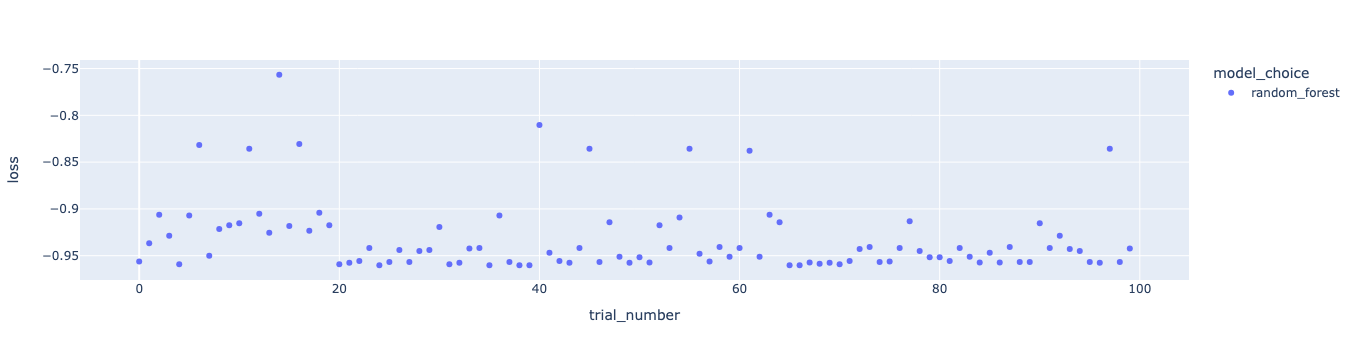

In [65]:
import pandas as pd
import numpy as np

import plotly.express as px

def unpack(x):
    if x:
        return x[0]
    return np.nan
  
def add_hover_data(fig, df, model_choice, ignore_cols=["loss", "trial_number", "model_choice"]):
  fig.update_traces(
      customdata = df.loc[df["model_choice"] == model_choice],
      hovertemplate = "<br>".join(
          [
              f"{col}: %{{customdata[{i}]}}"
              for i, col in enumerate(df.columns) if not trials_df.loc[trials_df["model_choice"] == model_choice][col].isnull().any() 
            and col not in ignore_cols
          ]
      ),
      selector = {"name": model_choice},
  )
  return fig


trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in spark_trials])
trials_df["loss"] = [t["result"]["loss"] for t in spark_trials]
trials_df["trial_number"] = trials_df.index
trials_df["model_choice"] = trials_df["model_choice"].apply(
    lambda x: "random_forest" if x == 0 else "gradient_boosting"
)
fig = px.scatter(trials_df, x="trial_number", y="loss", color="model_choice")
fig = add_hover_data(fig, trials_df, "random_forest")
fig.show()

Because we have lots of experiments in MLFlow now and they are all nested under our experiment container cmle_hyperopt_tuning, we need to first find out the experiment run ID from the parent so we can then filter based on that to find the individual trials.

In [66]:
parent_run = mlflow.search_runs(filter_string=f'tags.mlflow.runName = "{model_name}_hyperopt_tuning"').iloc[0]
print(parent_run)

run_id                                      4560ca6dfa8044fda47d2ee05377dc25
experiment_id                                                              0
status                                                              FINISHED
artifact_uri               file:///mlruns/0/4560ca6dfa8044fda47d2ee05377d...
start_time                                  2023-08-08 21:03:51.563000+00:00
end_time                                    2023-08-08 21:06:22.666000+00:00
tags.mlflow.user                                                        root
tags.mlflow.runName                    cmle_propensity_model_hyperopt_tuning
tags.mlflow.source.type                                                LOCAL
tags.mlflow.source.name    /usr/local/lib/python3.8/site-packages/ipykern...
Name: 0, dtype: object


In [67]:
parent_run_id = mlflow.search_runs(filter_string=f'tags.mlflow.runName = "{model_name}_hyperopt_tuning"').iloc[0].run_id
print(parent_run_id)

4560ca6dfa8044fda47d2ee05377dc25


And finally we find and record the best overall performing model. Because this one is the best overall, we create a brand new model in the Model Hub and this is the model we'll be using going forward for scoring.

We organize the run info associated with the above hyperparameter search and print this out

In [68]:
def print_run_info(runs):
    for r in runs:
        print("run_id: {}".format(r.info.run_id))
        print("lifecycle_stage: {}".format(r.info.lifecycle_stage))
        print("metrics: {}".format(r.data.metrics))

        # Exclude mlflow system tags
        tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
        print("tags: {}".format(tags))

In [69]:
from mlflow import MlflowClient
client = MlflowClient()
experiment_id=0
#runs = client.search_runs(parent_run_id, order_by=["metrics.m DESC"])
runs = client.search_runs(str(experiment_id), order_by=["metrics.auc DESC"])
print_run_info(runs)

run_id: 2080126a4eee4466957a35172fbe9837
lifecycle_stage: active
metrics: {'auc': 0.9602040816326531}
tags: {'model_choice': 'random_forest'}
run_id: 7fbd92ee73ee4288ab841c9ad25c1fc3
lifecycle_stage: active
metrics: {'auc': 0.9602040816326531}
tags: {'model_choice': 'random_forest'}
run_id: 099722a0daf144bfa25bf43c9d40eb24
lifecycle_stage: active
metrics: {'auc': 0.9602040816326531}
tags: {'model_choice': 'random_forest'}
run_id: f9193dc873e24b29b0afc62574781880
lifecycle_stage: active
metrics: {'auc': 0.9602040816326531}
tags: {'model_choice': 'random_forest'}
run_id: 26e110d3ffcd4a2ea1e3e28638d55f13
lifecycle_stage: active
metrics: {'auc': 0.9602040816326531}
tags: {'model_choice': 'random_forest'}
run_id: b7ecfc5a8b3c4445b09af111f0fdae52
lifecycle_stage: active
metrics: {'auc': 0.9602040816326531}
tags: {'model_choice': 'random_forest'}
run_id: c1fe770d324741abbe68bf789e4f2d8f
lifecycle_stage: active
metrics: {'auc': 0.9591836734693878}
tags: {'model_choice': 'random_forest'}
run_id

We identify the best model and print out its quality oriented characteristics

In [70]:
import json
best_run_global_auc = runs[0].data.metrics["auc"]
best_run_id_global = json.loads(runs[0].data.tags['mlflow.log-model.history'])[0]["run_id"]
print(f"Best global run ID: {best_run_id_global}")
print(f"Best global AUC: {best_run_global_auc}")

top_model_name = model_name
top_model_version = mlflow.register_model(f"runs:/{best_run_id_global}/hyperopt_model", top_model_name)
time.sleep(15)

Registered model 'cmle_propensity_model' already exists. Creating a new version of this model...
2023/08/08 21:08:25 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: cmle_propensity_model, version 5


Best global run ID: 2080126a4eee4466957a35172fbe9837
Best global AUC: 0.9602040816326531


Created version '5' of model 'cmle_propensity_model'.


In [71]:
from mlflow.tracking import MlflowClient
 
client = MlflowClient()
client.transition_model_version_stage(
  name=top_model_name,
  version=top_model_version.version,
  stage="Production",
)

<ModelVersion: aliases=[], creation_timestamp=1691528905092, current_stage='Production', description=None, last_updated_timestamp=1691528920114, name='cmle_propensity_model', run_id='2080126a4eee4466957a35172fbe9837', run_link=None, source='file:///mlruns/0/2080126a4eee4466957a35172fbe9837/artifacts/hyperopt_model', status='READY', status_message=None, tags={}, user_id=None, version=5>

In [72]:
prod_model = mlflow.pyfunc.load_model(f"models:/{top_model_name}/production")
 
# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, prod_model.predict(X_test))}')

AUC: 0.9602040816326531


In [73]:
!pip install matplotlib

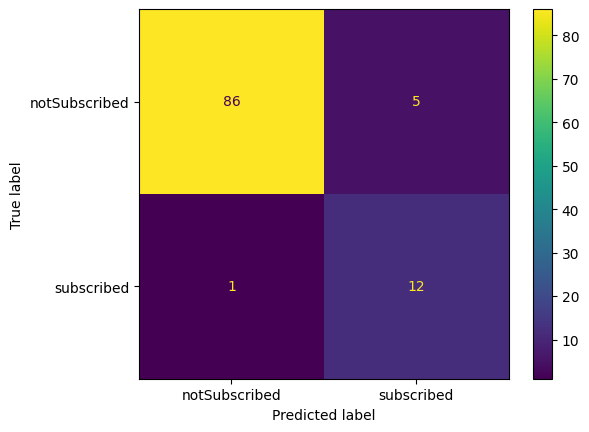

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

predicted_probas = prod_model.predict(X)
predicted_probas[predicted_probas > 0.5] = 1
predicted_probas[predicted_probas <= 0.5] = 0
matrix = confusion_matrix(predicted_probas, y)
fig = ConfusionMatrixDisplay(matrix, display_labels=["notSubscribed", "subscribed"])
fig.plot()